In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/eurosat-dataset.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/landuse-scene-classification.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/NWPU-RESISC45.zip"
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/PatternNet.zip"

In [3]:
datasets_dir =  "/content/content/PatternNet"

In [5]:
IMG_SIZE = 64
BATCH_SIZE = 32
epochs = 20

In [6]:
import tensorflow as tf
tf.random.set_seed(42)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size =  (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names


Found 30400 files belonging to 38 classes.
Using 24320 files for training.
Found 30400 files belonging to 38 classes.
Using 6080 files for validation.


['airplane',
 'baseball_diamond',
 'basketball_court',
 'beach',
 'bridge',
 'cemetery',
 'chaparral',
 'christmas_tree_farm',
 'closed_road',
 'coastal_mansion',
 'crosswalk',
 'dense_residential',
 'ferry_terminal',
 'football_field',
 'forest',
 'freeway',
 'golf_course',
 'harbor',
 'intersection',
 'mobile_home_park',
 'nursing_home',
 'oil_gas_field',
 'oil_well',
 'overpass',
 'parking_lot',
 'parking_space',
 'railway',
 'river',
 'runway',
 'runway_marking',
 'shipping_yard',
 'solar_panel',
 'sparse_residential',
 'storage_tanks',
 'swimming_pool',
 'tennis_court',
 'transformer_station',
 'wastewater_treatment_plant']

In [7]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

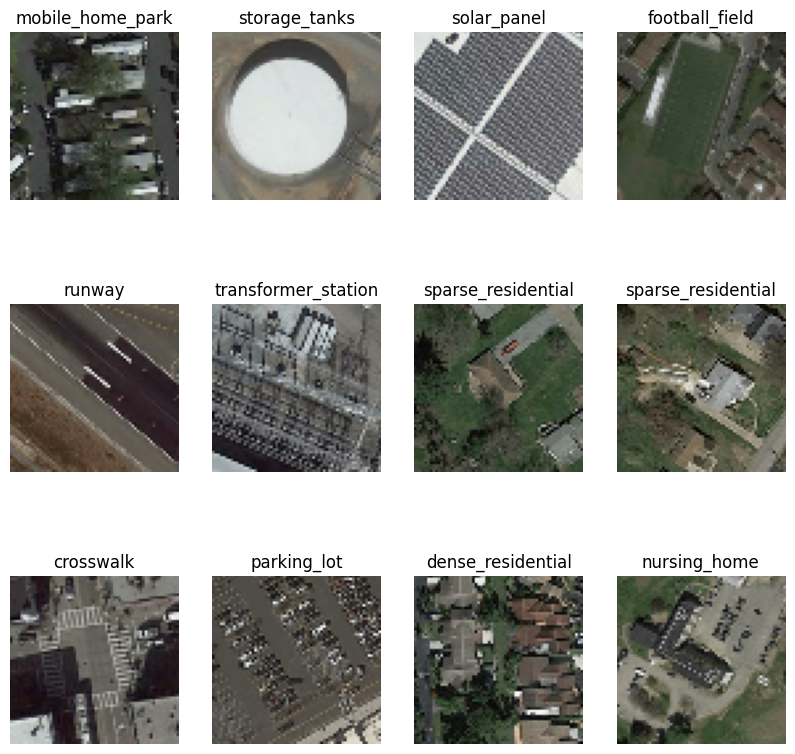

In [8]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10,10))

for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

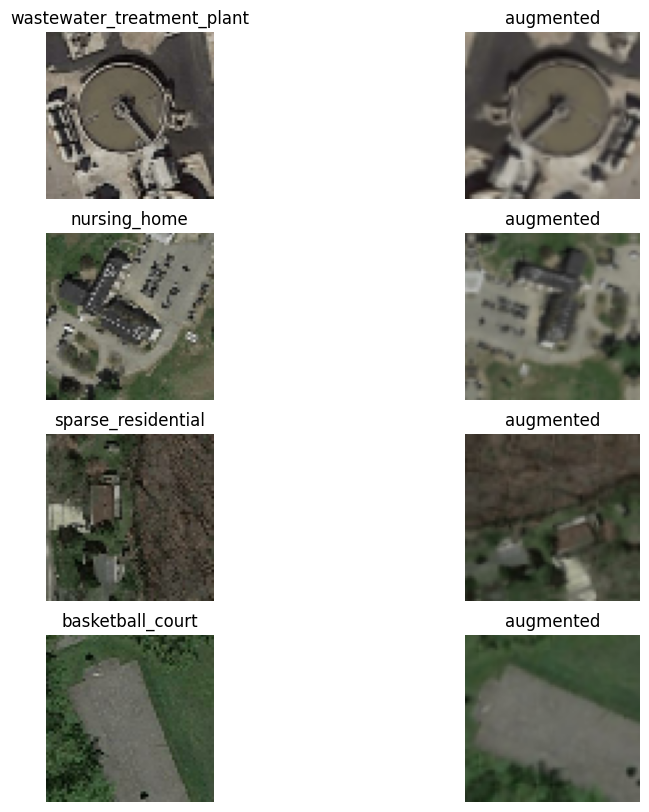

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        img = augmented_image_batch[i]
        img = np.array(img, dtype=np.int32)
        plt.imshow(img)
        plt.title(f"augmented")
        plt.axis("off")

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, None, None, 3)        0         ['input_layer[0][0]']         
 ial)                                                                                             
                                                                                                  
 efficientnetb0 (Functional  (None, None, None, 1280)     4049571   ['data_augmentation[0][0]']   
 )                                                                                                
                             

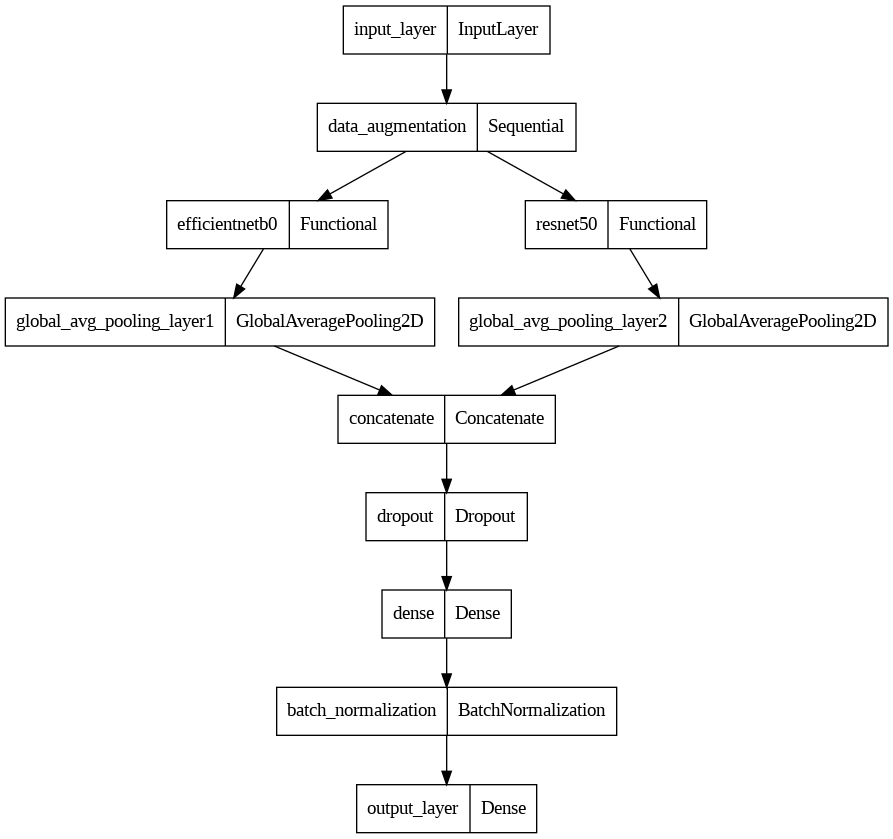

In [10]:
import tensorflow as tf

# Setup the base models and freeze their layers (this will extract features)
base_model1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model2 = tf.keras.applications.ResNet50(include_top=False)

base_model1.trainable = True  # Enable fine-tuning
base_model2.trainable = True  # Enable fine-tuning

# Fine-tune only the last N layers
fine_tune_at = 50
for layer in base_model1.layers[:-fine_tune_at]:
    layer.trainable = False

fine_tune_at = 20
for layer in base_model2.layers[:-fine_tune_at]:
    layer.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
x = data_augmentation(inputs)
x1 = base_model1(x, training=False)
x2 = base_model2(x, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer1')(x1)
x2 = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer2')(x2)
x = tf.keras.layers.concatenate([x1, x2])


x = tf.keras.layers.Dropout(0.4)(x)  # Adjust dropout rate
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add dense layer with L2 regularization
x = tf.keras.layers.BatchNormalization()(x)  # Add batch normalization
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adjust the learning rate
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Learning rate schedule callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

model.summary()
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    dpi=96,
)


In [11]:
# Train the model with the learning rate schedule
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
760/760 [==============================] - 137s 146ms/step - loss: 4.1520 - accuracy: 0.7948 - val_loss: 2.7066 - val_accuracy: 0.8962 - lr: 1.0000e-04
Epoch 2/20
760/760 [==============================] - 56s 74ms/step - loss: 1.9876 - accuracy: 0.9231 - val_loss: 1.4609 - val_accuracy: 0.9266 - lr: 1.0000e-04
Epoch 3/20
760/760 [==============================] - 49s 64ms/step - loss: 1.1172 - accuracy: 0.9389 - val_loss: 0.9236 - val_accuracy: 0.9196 - lr: 1.0000e-04
Epoch 4/20
760/760 [==============================] - 46s 60ms/step - loss: 0.6883 - accuracy: 0.9457 - val_loss: 0.5814 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 5/20
760/760 [==============================] - 47s 62ms/step - loss: 0.4738 - accuracy: 0.9500 - val_loss: 0.4511 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 6/20
760/760 [==============================] - 47s 61ms/step - loss: 0.3564 - accuracy: 0.9553 - val_loss: 0.3737 - val_accuracy: 0.9419 - lr: 1.0000e-04
Epoch 7/20
760/760 [============

In [12]:
# Evaluate the model on both training and testing sets
model.evaluate(train_data), model.evaluate(test_data)

190/190 [==============================] - 6s 32ms/step - loss: 0.1796 - accuracy: 0.9594


([0.13069114089012146, 0.9690789580345154],
 [0.17964521050453186, 0.9593750238418579])

In [13]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

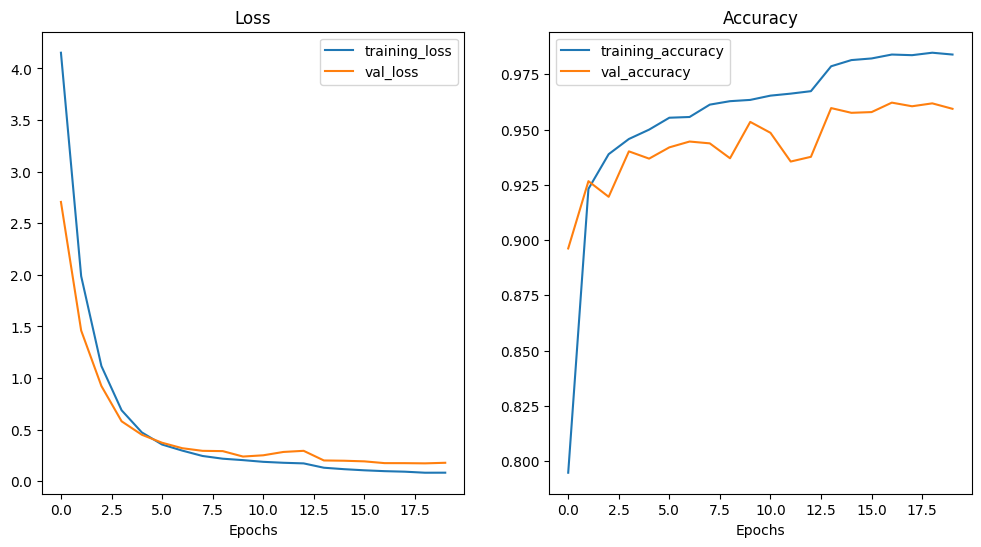

In [14]:
plot_loss_curves(history)

In [15]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

# Display classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

1/1 [==============================] - 0s 29ms/step
Classification Report:
                             precision    recall  f1-score   support

                  airplane       0.98      1.00      0.99       154
          baseball_diamond       0.99      0.99      0.99       152
          basketball_court       0.75      0.93      0.83       169
                     beach       1.00      1.00      1.00       146
                    bridge       0.95      0.99      0.97       156
                  cemetery       0.97      0.99      0.98       155
                 chaparral       1.00      1.00      1.00       171
       christmas_tree_farm       0.99      1.00      1.00       158
               closed_road       0.99      0.87      0.93       166
           coastal_mansion       0.95      0.93      0.94       136
                 crosswalk       0.96      0.94      0.95       151
         dense_residential       0.94      0.90      0.92       134
            ferry_terminal       0.98  

Class counts: [154 151 157 146 154 155 171 158 160 127]


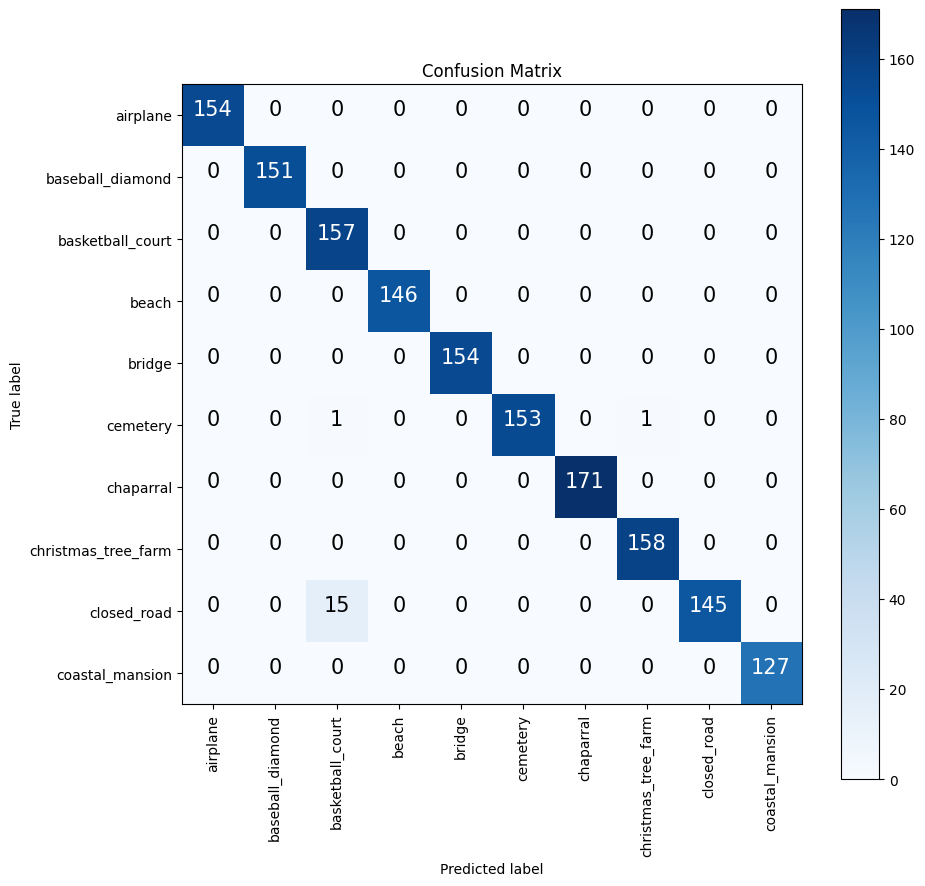

In [16]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False):

    # Create the confusion matrix for the selected classes
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Select only the first 10 classes
    conf_matrix_subset = conf_matrix[:10, :10]

    # Print the sum of instances for each class
    print("Class counts:", np.sum(conf_matrix_subset, axis=1))

    # Normalize the confusion matrix if specified
    if norm:
        conf_matrix_norm = conf_matrix_subset.astype("float") / conf_matrix_subset.sum(axis=1)[:, np.newaxis]
    else:
        conf_matrix_norm = None

    n_classes = conf_matrix_subset.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(conf_matrix_subset, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes[:n_classes]
    else:
        labels = np.arange(n_classes)

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=labels,  # axes will be labeled with class names (if they exist) or ints
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.tick_params(axis='x', labelrotation=90)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (conf_matrix_subset.max() + conf_matrix_subset.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(conf_matrix_subset.shape[0]), range(conf_matrix_subset.shape[1])):
        if norm:
            plt.text(j, i, f"{conf_matrix_subset[i, j]} ({conf_matrix_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if conf_matrix_subset[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{conf_matrix_subset[i, j]}",
                     horizontalalignment="center",
                     color="white" if conf_matrix_subset[i, j] > threshold else "black",
                     size=text_size)

# Assuming y_true and y_pred have been calculated
y_true_subset = y_true[y_true < 10]
y_pred_subset = y_pred[y_true < 10]

# Assuming class_names is defined
make_confusion_matrix(y_true_subset, y_pred_subset, classes=class_names[:32])
plt.show()


1/1 [==============================] - 0s 28ms/step


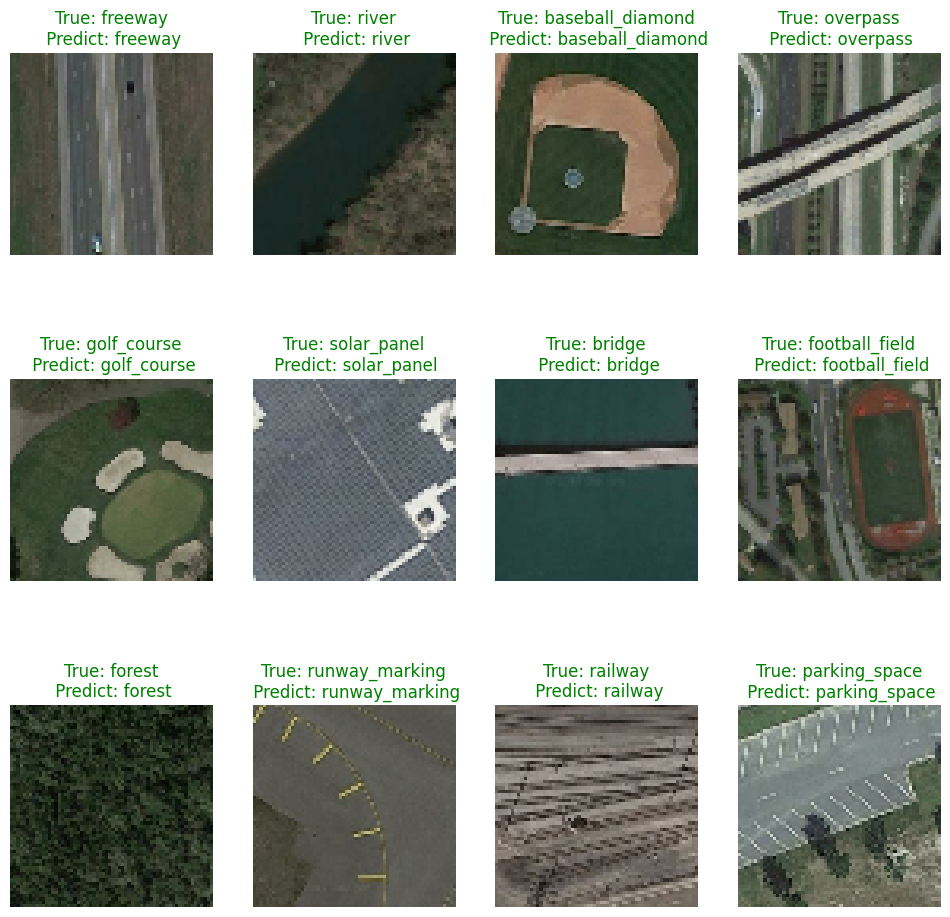

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")